# Image recognition android application project
- Flower image classification with Baseline CNN (20200823)  
- 4685 training set with 5 class, 100 iterations, 64 batch
### Reference
- [Advanced Computer Vision with TensorFlow], https://stephan-osterburg.gitbook.io/coding/coding/ml-dl/tensorfow

## 1. Import packages

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import tarfile
import glob
from six.moves import urllib
from glob import glob
import random
import shutil

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import load_model
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

## 2. Load and Explore the Flower Dataset

In [3]:
def load_data_files(base_dir):
    folder_name = "dataset/flower_photos"
    RAW_DATASET = os.path.join(base_dir, folder_name)

    abs_dir = os.path.join(os.getcwd(), folder_name)
    sub_dir = os.listdir(abs_dir)
    data_dic = {}
    
    for class_name  in sub_dir:
        imgs = glob(os.path.join(RAW_DATASET,class_name,"*.jpg"))

        data_dic[class_name] = imgs
        print("Class: {}".format(class_name))
        print("Number of images: {} \n".format(len(imgs)))

    return data_dic

In [4]:
BASE_DIR = os.getcwd()
data_dic = load_data_files(BASE_DIR)

Class: daisy
Number of images: 1020 

Class: dandelion
Number of images: 1277 

Class: roses
Number of images: 1124 

Class: sunflowers
Number of images: 1158 

Class: tulips
Number of images: 1275 



## 3. Split train and validation dataset

In [5]:
# Create new directory and copy files to it
def copy_files_to_directory(files, directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print("Created directory: {}".format(directory))

    for f in files:
        shutil.copy(f, directory)
    print("Copied {} files.\n".format(len(files)))

In [6]:
def train_validation_split(base_dir, data_dic, split_ratio=0.2):
    FLOWER_DATASET = os.path.join(base_dir,"flower_dataset")

    if not os.path.exists(FLOWER_DATASET):
        os.makedirs(FLOWER_DATASET)

    for class_name, imgs in data_dic.items():
        idx_split = int(len(imgs) * split_ratio)
        random.shuffle(imgs)
        validation = imgs[:idx_split]
        train = imgs[idx_split:]

        copy_files_to_directory(train, os.path.join(FLOWER_DATASET,"train",class_name))
        copy_files_to_directory(validation, os.path.join(FLOWER_DATASET,"validation",class_name))

In [7]:
BASE_DIR = os.getcwd()

train_validation_split(BASE_DIR, data_dic, split_ratio=0.2)

Created directory: C:\Users\eilee\Desktop\Trinity\어플 프로젝트\20200823_Model_Selection_with_more_data\flower_dataset\train\daisy
Copied 816 files.

Created directory: C:\Users\eilee\Desktop\Trinity\어플 프로젝트\20200823_Model_Selection_with_more_data\flower_dataset\validation\daisy
Copied 204 files.

Created directory: C:\Users\eilee\Desktop\Trinity\어플 프로젝트\20200823_Model_Selection_with_more_data\flower_dataset\train\dandelion
Copied 1022 files.

Created directory: C:\Users\eilee\Desktop\Trinity\어플 프로젝트\20200823_Model_Selection_with_more_data\flower_dataset\validation\dandelion
Copied 255 files.

Created directory: C:\Users\eilee\Desktop\Trinity\어플 프로젝트\20200823_Model_Selection_with_more_data\flower_dataset\train\roses
Copied 900 files.

Created directory: C:\Users\eilee\Desktop\Trinity\어플 프로젝트\20200823_Model_Selection_with_more_data\flower_dataset\validation\roses
Copied 224 files.

Created directory: C:\Users\eilee\Desktop\Trinity\어플 프로젝트\20200823_Model_Selection_with_more_data\flower_dataset

## 4. Image preprocessing

In [14]:
batch_size = 64
num_classes = 5
epochs = 100

In [9]:
preprocessing_image = tf.keras.preprocessing.image

train_datagen = preprocessing_image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = preprocessing_image.ImageDataGenerator(rescale=1./255)

In [10]:
BASE_DIR = os.getcwd()

train_generator = train_datagen.flow_from_directory(
    os.path.join(BASE_DIR, "flower_dataset/train"),
    target_size=(32, 32),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    os.path.join(BASE_DIR, "flower_dataset/validation"),
    target_size=(32, 32),
    batch_size=batch_size,
    class_mode='categorical')

Found 4685 images belonging to 5 classes.
Found 1169 images belonging to 5 classes.


## 5. Baseline CNN model

In [16]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding='same',
                 activation='relu',
                 input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 32)        2432      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)             

In [17]:
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer=adam(lr=0.0005), metrics=['accuracy'])

## 6. Training

In [18]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = 4685//batch_size,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps=20)

Epoch 1/100
73/73 [==============================] - 17s 240ms/step - loss: 1.5994 - accuracy: 0.2391 - val_loss: 1.5720 - val_accuracy: 0.3893
Epoch 2/100
73/73 [==============================] - 18s 247ms/step - loss: 1.5344 - accuracy: 0.3499 - val_loss: 1.5636 - val_accuracy: 0.4217
Epoch 3/100
73/73 [==============================] - 18s 243ms/step - loss: 1.4219 - accuracy: 0.3960 - val_loss: 1.3149 - val_accuracy: 0.4493
Epoch 4/100
73/73 [==============================] - 18s 250ms/step - loss: 1.3271 - accuracy: 0.4335 - val_loss: 1.1570 - val_accuracy: 0.4761
Epoch 5/100
73/73 [==============================] - 19s 264ms/step - loss: 1.2893 - accuracy: 0.4499 - val_loss: 1.1891 - val_accuracy: 0.4720
Epoch 6/100
73/73 [==============================] - 18s 240ms/step - loss: 1.2436 - accuracy: 0.4713 - val_loss: 1.2383 - val_accuracy: 0.4939
Epoch 7/100
73/73 [==============================] - 18s 243ms/step - loss: 1.2167 - accuracy: 0.4932 - val_loss: 1.2347 - val_accuracy:

## 7. Accuracy Analysis and Visualization

In [19]:
def plot_accuracy_and_loss(history):
    plt.figure(1, figsize= (15, 10))

    # plot train and test accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Baseline CNN Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # plot train and test loss
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Baseline CNN loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')

    plt.show()

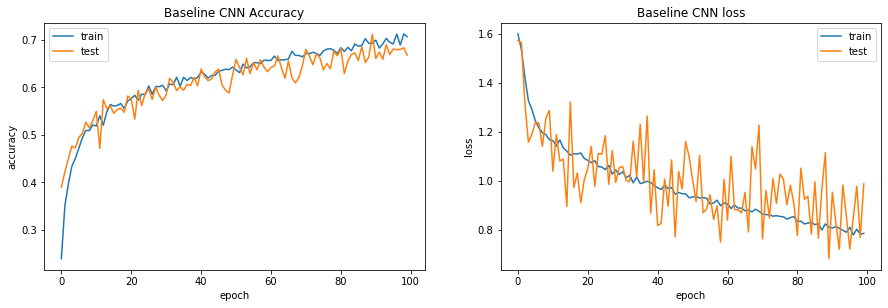

In [20]:
plot_accuracy_and_loss(history)

In [22]:
print("-- Evaluate --")

scores_train = model.evaluate_generator(
            train_generator, 
            steps = 5)
scores_val = model.evaluate_generator(
            validation_generator, 
            steps = 5)

print("%s: %.2f%%" %(model.metrics_names[1], scores_train[1]*100))
print("%s: %.2f%%" %(model.metrics_names[1], scores_val[1]*100))

print("-- Predict --")
output_train = model.predict_generator(train_generator, steps=5)
output_val = model.predict_generator(validation_generator, steps=5)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

print(train_generator.class_indices)
print(output_train)

print(validation_generator.class_indices)
print(output_val)

-- Evaluate --
accuracy: 72.19%
accuracy: 70.00%
-- Predict --
{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}
[[0.021 0.001 0.633 0.002 0.343]
 [0.005 0.019 0.000 0.971 0.004]
 [0.090 0.021 0.402 0.110 0.377]
 ...
 [0.057 0.486 0.206 0.032 0.219]
 [0.006 0.000 0.941 0.000 0.052]
 [0.993 0.002 0.002 0.001 0.003]]
{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}
[[0.955 0.034 0.008 0.001 0.002]
 [0.061 0.520 0.035 0.045 0.340]
 [0.086 0.032 0.005 0.860 0.017]
 ...
 [0.000 0.001 0.000 0.941 0.058]
 [0.899 0.021 0.057 0.000 0.024]
 [0.025 0.928 0.036 0.000 0.010]]


## 8. Save and Load model

In [23]:
# save model architecture
model_json = model.to_json()
open('1_model.json', 'w').write(model_json)

# save model's learned weights
model.save_weights('1_weights.h5', overwrite=True)

In [24]:
# Load trained model
from keras.models import model_from_json 

json_file = open("1_model.json", "r")
loaded_model_json = json_file.read() 
json_file.close()
loaded_model = model_from_json(loaded_model_json)
 
# model weight load 
loaded_model.load_weights("1_weights.h5")
print("Loaded model from disk")

Loaded model from disk
